In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp

$$g_j = e^{jpx} cos (2\pi j qx) $$

In [ ]:
M = 5
x_node = np.linspace(0, 1, M+1)
x_center = (x_node[:-1] + x_node[1:]) * 0.5
plt.plot(x_node, np.ones(M+1), '|')
plt.plot(x_center, np.ones(M), 'x')

In [ ]:
M = 5
N = 30
p = -0.05
q = 0.1
j = 0
g_j = np.exp(j*p*x_node) * np.cos(2*np.pi*q*j*x_node)

In [ ]:
data = np.ones((2, M+1))*0.5
data

In [ ]:
M = 100
N = 30
p = -0.05
q = 0.1
x_node = np.linspace(0, 1, M+1)
x_center = (x_node[1:] + x_node[:-1]) * 0.5
G_node = np.zeros((M+1, N))
for j in range(0, N):
    G_node[:,j] = np.exp(j*p*x_node) * np.cos(2*np.pi*q*j*x_node)
dx = np.diff(x_node)    
Av = sp.spdiags(np.ones((2, M+1))*0.5, [0, 1], M, M+1)
dx_diag = sp.spdiags(dx, [0], M, M)
G = G_node.T @ Av.T @  dx_diag 

In [ ]:
def get_G_matrix(M, N, p, q, j0=1, jN=30):
    """
    Comments
    """
    x_node = np.linspace(0, 1, M+1)
    x_center = (x_node[1:] + x_node[:-1]) * 0.5
    G_node = np.zeros((M+1, N))
    j_values = np.linspace(j0, jN, N)
    for jj, j in enumerate(j_values):
        G_node[:,jj] = np.exp(j*p*x_node) * np.cos(2*np.pi*q*j*x_node)
    dx = np.diff(x_node)    
    Av = sp.spdiags(np.ones((2, M+1))*0.5, [0, 1], M, M+1)
    dx_diag = sp.spdiags(dx, [0], M, M)
    G = G_node.T @ Av.T @  dx_diag     
    return G, x_center

In [ ]:
def get_model(
    x_centers, 
    x_boxcar_min=0.6, x_boxcar_max=0.8, amplitude_boxcar=0.5, 
    x0_gaussian=0.3, sigma_gaussian=0.07, amplitude_gaussian=0.35
):
    
    # initialize empty model
    model = np.zeros_like(x_centers)

    # create boxcar
    inds_boxcar = (x_centers > x_boxcar_min) & (x_centers < x_boxcar_max)
    model[inds_boxcar] = amplitude_boxcar

    # define_gaussian
    def gaussian(x, x0, sigma): 
        return np.exp(-(x - x0)**2 / (2*sigma**2))

    return model + amplitude_gaussian * gaussian(x_centers, x0_gaussian, sigma_gaussian)

In [ ]:
m = get_model(
    x_center,
    x_boxcar_min=0.6, 
    x_boxcar_max=0.8, 
    amplitude_boxcar=0.5,
    x0_gaussian=0.3, 
    sigma_gaussian=0.1, 
    amplitude_gaussian=0.35
)
plt.plot(x_center, m)

In [ ]:
M = 100
N = 30
p = -0.05
q = 0.1
G, x_center = get_G_matrix(M, N, p, q, j0=1, jN=30)
# m = np.zeros(M)
# box_index = np.logical_and(x_center>0.2, x_center<0.4)
# m[box_index] = 1.
m = get_model(x_center)

dpred = G @ m 

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

ax[0].plot(x_center, m)
ax[1].plot(x_center, G.T)
ax[2].plot(dpred, "-o", color="k")

ax[0].set_title("model")
ax[1].set_title("kernels")
ax[2].set_title("data")

plt.tight_layout();

In [ ]:
# i_column = 30
# out = plt.plot(x_center, G.T[:,:i_column])

In [ ]:
G.shape

In [ ]:
e = np.ones((20, 10))

In [ ]:
vec = np.arange(10)
vec

In [ ]:
# plt.plot(x_node, G_node.T)

# Let's invert

In [ ]:
dpred = G@m
dobs = dpred.copy()

In [ ]:
plt.plot(dpred)

In [ ]:
m_est = np.linalg.solve(G.T @ G, G.T @ dpred)

In [ ]:
plt.plot(x_center, m_est)
plt.plot(x_center, m)

## It does not work just with the data

## Let's add a regularization term

In [ ]:
phi_m = np.linalg.norm(m)**2

In [ ]:
M = 100

 $$\phi(m) = \phi_d(m) + \beta \phi_m(m)$$

$$ \phi_m = \alpha_s \int (m-m_{ref})^2 + \alpha_z \int (\frac{dm}{dz})^2$$

$$ \alpha_s \| W_s m\|^2 + \alpha_z \| W_x m\|^2$$

In [ ]:
h = np.diff(x_node)
Ws = sp.spdiags(np.ones(M) * np.sqrt(h), [0], M, M)
e = np.ones(M)
Av = sp.spdiags(np.ones((2, M+1))*0.5, [0, 1], M, M+1)
Wx = sp.spdiags(np.vstack((-e/h, e/h)) * np.sqrt(h), [0, 1], M-1, M)
alpha_s = 1./h[0]**2
alpha_x = 1.

27.053057016270845


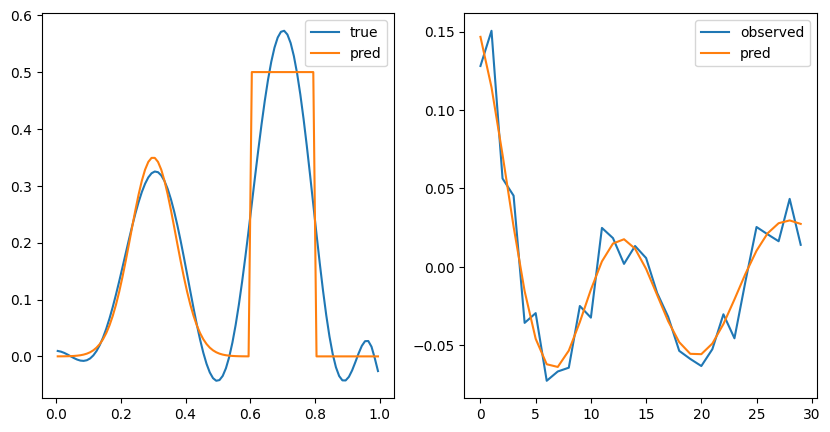

In [47]:
beta = 1e-7
rerr = 0.1
floor = 0.01
noise = np.random.randn(len(dpred)) * abs(dpred) * rerr + np.random.randn(len(dpred)) * floor
dobs = dpred.copy() + noise

data_std = rerr * abs(dobs) + floor

Wd = sp.spdiags(1./data_std, [0], N, N)
m_est_reg = np.linalg.solve(G.T @ Wd.T @ Wd @ G + beta*alpha_s*(Ws.T@ Ws) + beta*alpha_x*(Wx.T@ Wx), G.T @ Wd.T @ Wd @ dpred)
print (np.linalg.norm(Wd @ (G@m_est_reg - dobs))**2)
fig, axs = plt.subplots(1,2, figsize=(10, 5))
ax1, ax2 = axs
ax1.plot(x_center, m_est_reg, label='true')
ax1.plot(x_center, m, label='pred')

ax2.plot(dobs, label='observed')
ax2.plot(G@m_est_reg, label='pred')
for ax in axs:
    ax.legend()

In [96]:
betas = np.logspace(-16, 2, 100)
phi_ds = []
phi_ms = []
ms = []
for beta in betas:
    m_est_reg = np.linalg.solve(G.T @ Wd.T @ Wd @ G + beta*alpha_s*(Ws.T@ Ws) + beta*alpha_x*(Wx.T@ Wx), G.T @ Wd.T @ Wd @ dpred)
    phi_d = np.linalg.norm(Wd @ (G@m_est_reg - dobs))**2
    phi_m = alpha_s * np.linalg.norm(Ws@m_est_reg)**2 + alpha_x * np.linalg.norm(Wx@m_est_reg)**2
    phi_ds.append(phi_d)
    phi_ms.append(phi_m)
    ms.append(m_est_reg)

In [97]:
from ipywidgets import widgets, interact

In [103]:
ii = 30
def foo(ii):
    fig, axs = plt.subplots(1,3, figsize=(12,3))
    ax, ax1, ax2 = axs
    ax.plot(phi_ms, phi_ds, '.-')
    ax.plot(phi_ms[ii], phi_ds[ii], 'ro')
    xlim = ax.get_xlim()
    ax.plot([xlim[0], xlim[1]], [30, 30], 'k')    
    ax.set_xlim(xlim)
    ax.set_xlabel("$\phi_m$")
    ax.set_ylabel("$\phi_d$")
    ax1.plot(x_center, ms[ii], label='pred', color='C1')
    ax1.plot(x_center, m, label='true', color='C0')
    ax1.legend()
    ax2.plot(dobs, label='observed')
    ax2.plot(G@ms[ii], label='pred')
    ax2.legend()
    ax.set_title(f"Beta= {betas[ii]:.1e}")
interact(foo, ii=widgets.IntSlider(min=0, max=len(phi_ds)-1, step=1))

interactive(children=(IntSlider(value=0, description='ii', max=99), Output()), _dom_classes=('widget-interact'…

<function __main__.foo(ii)>

In [59]:
len(dobs)

30